In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle


import torch
from torch.utils.data import DataLoader, Dataset


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

from Preprocessing import *
from ExtractGenre import *
from CNN_ExtractGenre import *

import DatasetLoader as DL
import Model as M

# Cleaning data

Apply the functions in Preprocessing.py to clean the midi dataset. There are multiple files that are currupted. 
For this analysis we are also going to use only Midi file with a timestamp of 4/4, like in the reference paper. This filtering is done in CleaningData()

In [12]:
CleaningData()

Cleaning Data : 100%|██████████| 2200/2200 [10:32<00:00,  3.48it/s]


# Preprocessing data:

Firstly we reconstruct the database, transforming all the polyphonic audios into monophonic, keeping the information about the tracks in the midi file. It is done by keeping only the highest pitch from each polyphonic note.

In [13]:
RecreateDatabase()

Recreating Database : 100%|██████████| 2079/2079 [14:22<00:00,  2.41it/s] 


The input of the model has to be a 128x16 matrix as in the paper. The following function clasify the midi tracks into 7 instrumental classes:
- String
- Keyboard
- Aereophone
- Percussion
- Voice
- Synth
- Others

In [3]:
Dataset = PreProcessing(nDir = 1000)

Preprocessing: 100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


In [ ]:
# with open('Dataset.pkl', 'wb') as f:
#    pickle.dump(Dataset, f)

with open('Dataset.pkl', 'rb') as f:
   Dataset = pickle.load(f)

for key, value in Dataset.items():
   print(key, '', len(value['Tempo']))

# Genre Detection

Music genre classification generally relies on supervised learning approaches with labeled datasets and it is usually a very difficult taks. Even wors, MIDI dataset does not holds the information about genre, transforming this into an **unsupervised learning** task where we must discover hidden patterns and group similar musical pieces without prior knowledge of their categories.

We employ a feature-based clustering methodology to identify distinct musical genres within our dataset. The core strategy involves extracting meaningful musical characteristics from MIDI files and applying clustering algorithms to reveal natural groupings that correspond to different musical styles.

**Whole-song analysis**: We compute global features that capture the overall characteristics of each piece, including tempo, rhythmic patterns, melodic range, and dynamic properties. These features represent what a listener perceives when hearing the complete musical work.

**Track-level aggregation**: Since MIDI files contain multiple instrumental tracks, we extract features from individual tracks and then aggregate them using statistical measures (mean, maximum, standard deviation). This approach provides insights into instrumental diversity, arrangement complexity, and the interaction between different musical parts while maintaining a consistent feature vector size across songs with varying numbers of tracks.

Our feature set comprises **22 carefully selected attributes** spanning multiple musical dimensions:

- **Rhythmic features**: Tempo, rhythmic regularity, syncopation level, and note density
- **Melodic features**: Pitch range, average pitch, melodic direction changes, and interval patterns  
- **Dynamic features**: Velocity characteristics and dynamic contrast
- **Structural features**: Song length and melodic complexity measures
- **Instrumentation features**: Instrument family ratios and ensemble diversity metrics

This comprehensive feature representation captures the essential characteristics that distinguish different musical genres, from the rhythmic complexity of jazz to the harmonic richness of classical music, enabling unsupervised algorithms to identify meaningful musical categories within our dataset.

The identification of the genre of the song helps us to train specific model that can generate songs with specific characteristics

In [5]:
Features = Clustering()

100%|██████████| 2050/2050 [04:11<00:00,  8.14it/s]

Number of Excluded songs: 7


In [2]:
# with open('Features.pkl', 'wb') as f:
#    pickle.dump(Features, f)

with open('Features.pkl', 'rb') as f:
   Features = pickle.load(f)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


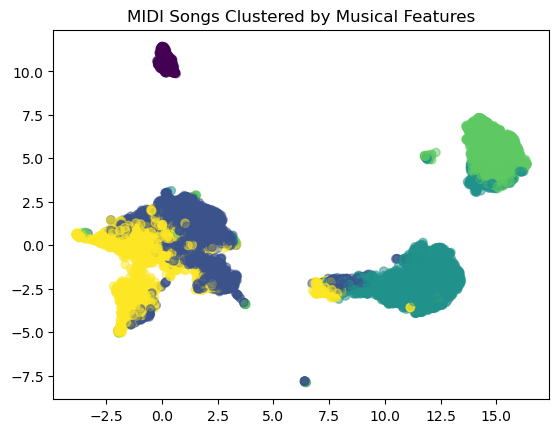

In [3]:
np.random.seed(50)

Scaler = StandardScaler()
NormFeatures = Scaler.fit_transform(list(Features.values()))

Kmeans = KMeans(n_clusters = 5, random_state=13)
clusters = Kmeans.fit_predict(NormFeatures)

reducer = umap.UMAP(n_components=2, random_state=42)
features_2d = reducer.fit_transform(NormFeatures)


plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha = 0.5, c=clusters, cmap='viridis')
plt.title('MIDI Songs Clustered by Musical Features')
plt.show()

In [4]:
ClusteringDF = pd.DataFrame([{'Song name': k, 'Features': v} for k, v in Features.items()])
ClusteringDF['Cluster'] = clusters
ClusteringDF

,Song name,Features,Cluster
0,Mel Carter/Band of Gold.mid,"[120, 0.007257802781121189, 0.6923076923076923...",3
1,Romina Power Al Bano/Sempre sempre.mid,"[121, 0.0005705919397250998, 0.716674407803065...",4
2,Romina Power Al Bano/Sha-e-o.mid,"[120, 0.0004483430644372761, 0.765859766277128...",4
3,"Romina Power Al Bano/Domani, domani.mid","[120, 0.007236628447971674, 0.6214285714285714...",3
4,Romina Power Al Bano/Felicita.1.mid,"[108, 0.00032781528784771953, 0.76200873362445...",4
...,...,...,...
11682,Thelma Houston/Don't Leave Me This Way.mid,"[120, 0.0003313859561314369, 0.834284355682358...",2
11683,Hawkins Erskine/Tuxedo Junction.mid,"[114, 0.026550282576501025, 0.4519670631290027...",3
11684,The Left Banke/Walk Away Renee.mid,"[120, 0.0005866290338205514, 0.654126213592233...",1
11685,Fortunes/Here Comes That Rainy Day Feeling Aga...,"[122, 0.0018174121448792696, 0.586016762240847...",2


As we can see, in the same cluster there are usually the songs belonging to the same artist, meaning the clustering algorithm seems to work at least fine

In [5]:
ClusteringDF[ClusteringDF['Cluster'] == 1]

,Song name,Features,Cluster
9,Pantera/Cowboys From Hell.mid,"[116, 0.0003622562165785167, 0.756279577721150...",1
11,Pantera/Planet Caravan.mid,"[86, 0.001030952470203046, 0.7273759939416887,...",1
13,Pantera/Mouth for War.mid,"[304, 0.004176452972460148, 0.7522433792952506...",1
14,Fiorello/San Martino.mid,"[128, 0.0002753194831056295, 0.834344279439447...",1
15,Fiorello/Spiagge.mid,"[123, 0.0002599501437034195, 0.802706443180070...",1
...,...,...,...
11652,Sergio Franchi/Mala femmena.mid,"[107, 0.002167753252360192, 0.6649794368870611...",1
11653,Sergio Franchi/Anema e core.mid,"[105, 0.0029658489843297532, 0.749161636485580...",1
11671,Oscar Peterson/I Want to Be Happy.mid,"[190, 0.004637171546370977, 0.8880767473732298...",1
11675,Oscar Peterson/When Your Lover Has Gone.mid,"[120, 0.0005249620416690875, 0.797546012269938...",1


And now we can do the same thing done in the Preprocessing function, wo subdivide, in each cluster, the macro family of instruments played in order to obtain the 128x16 matricies (bars)

In [ ]:
ClusterGenreDataset = GenrePrep(ClusteringDF, clusters)

100%|██████████| 3462/3462 [01:31<00:00, 38.04it/s]


In [ ]:
with open('ClusterGenreDataset.pkl', 'wb') as f:
   pickle.dump(ClusterGenreDataset, f)

# with open('ClusterGenreDataset.pkl', 'rb') as f:
#    ClusterGenreDataset = pickle.load(f)

As we can see the first cluster is the less populated one; analyzing the main instruments family inside it we can see there is only "Keyboard" instruments! Meaning the clustering algorithm has been able to recognize and clusterize this genre from the other. Unfortunatly there are too few bars to train the MidiNet

In [ ]:
#Only family present is Keyboard
np.shape(ClusterGenreDataset[0]['Keyboard']['Bars'])

(293, 128, 16)

In [ ]:
#In the cluster 1 there are almost 6000 bars os "String" instruments
np.shape(ClusterGenreDataset[1]['String']['Bars'])

(5937, 128, 16)

Clustering might be a good solution, but for a challenging task like genre recognition, it may not be enough. The idea, therefore, is to train a Convolutional Neural Network (CNN) to understand the structure of the songs and to implement a classifier capable of identifying the genre of each song in our MIDI dataset.

However, we cannot train the CNN directly on our MIDI dataset, since this would compromise both learning and classification. Moreover, CNNs are supervised learning models, and our dataset does not include genre labels. For this reason, we found another dataset containing 100 songs in .wav format for each of the following musical genres:

- metal
- disco
- classical
- hiphop
- jazz
- country
- pop
- blues 
- raggae 
- rock

The idea is to train the CNN using this labeled dataset. Before doing that, we need to perform some preprocessing, since some songs in the dataset are corrupted. Additionally, the audio clips are only a few seconds long, so we preprocess each song to have a fixed length and a consistent format. The preprocessing functions are implemented in the file **CNN_ExtractGenre.py**.

After preprocessing, we define the CNN model and the data loader in **Model.py** and **DataLoader.py**, respectively. The model is trained on Google Colab (not on the local machine), and we later load the trained model using its state_dict.

The CNN achieves a strong validation accuracy of 84%, as shown in the accompanying paper.

Once the model is trained on the labeled dataset, we use it to classify our own songs. This is a complex process because our songs are in .mid format, while the model expects .wav spectrograms as input. Therefore, each MIDI file must be converted into audio, transformed into a spectrogram, and then classified by the CNN.

After classifying each song, we save a file containing the song’s name and its predicted genre. From there, we proceed as before: we separate our dataset by genre, and within each genre, we further separate the songs by instrument.


N.B. all the function in the file **CNN_ExtractGenre** has already been runned since the computation is quite long. In the following cell we are showing the final result

In [ ]:
#Load the preprocessed and classified dataset:
with open('CNN_GenreDataset.pkl', 'rb') as f:
   CNN_GenreDataset = pickle.load(f)

#Mapping each genre into a number for classification
GenreMapping = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}


#Visualizing the shape of the dataset bars for rock songs, with string instrument 
np.shape(CNN_GenreDataset[9]['String']['Bars'])

(6495, 128, 16)

We now have three datasets available to train the MidiNet model:
1. Instrument-Only Dataset
This is the simplest version, where each song is categorized solely based on the instrument(s) played.
2.	Clustering-Based Genre Dataset
In this version, songs are first grouped by genre using clustering techniques, based on simple extracted features. Within each genre cluster, the songs are further categorized by instrument.
3. CNN-Based Genre Dataset
This version uses a Convolutional Neural Network (CNN) to classify each original song in the dataset by genre. Once a genre label is assigned, each song is then placed into its corresponding genre category and further divided by instrument.

# Model and Architecture

The class DatasetTransorm allow us to choose which intrument's bars to load. We can load from the simple dataset (1) or from (2) or (3), specifying the genre and the instrument's bar

In [ ]:
#We are selecting the data from the (3) dataset, rocks song played with string instruments
Data = DL.DatasetTransform(Genre = True, CNN = True, Cluster = 9, Instrument='String')
trainData = DataLoader(Data, batch_size=10, shuffle=True, num_workers=0)